# Project Title: Detection of cancer in breast ultrasound images 
Team: Sruthi Machina and Kishan B Shah

Link to the dataset: <https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset>

## Image analysis of Breast Ultra Sound Image dataset

### Import packages

In [26]:
import os
import re
import random
from pathlib import Path
from pprint import pprint
from skimage.filters import gaussian

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import skimage.feature
from skimage import exposure, data, img_as_float
from skimage.color import rgb2gray
from skimage.filters import prewitt_h,prewitt_v

from utils import init_img_dict, get_file_dicts, filter_files, find_mask, print_ndarray_info
from utils import img_read, img_write, img_resize, img_flip, comp_fft, histogram_equalization
from utils import display_img, display_img_list_3, display_3_imgs, display_3_hist, resize_imgs, flip_imgs, append_img_data

## Data structure to hold image information
We use a dictionary object to keep information for each image in the dataset. The datasets for the 3 classes are represented by 3 separate lists,  which contain a dictionary object for each file in the dataset. There are `133` images in normal image dataset, `437` in benign and `210` in malignant image dataset. For now, the dictionary object is initialized as
```
dict_object = {'file_name_fullpath': None, 'file_name': None, 
               'file_stem': None, 'file_suffix': None, 
               'file_masks': None}
```
Where `file_name_fullpath` is the image file name with full path, `file_name` is image file name without the path, `file_stem` is file name without the extension, `file_suffix` is the file extension and `file_masks` is a list containing masks (with full path) correponding to the image.

We will add more properties corresponding to images in the dictionary object, as needed. 

Example: In the directory containing images for benign cases, `./Dataset_BUSI_with_GT/benign`, there is an image file `benign (1).png`. The dictionary object (on Windows) is:
```
benign_img_list[0] = {
            'file_name_fullpath': './Dataset_BUSI_with_GT/benign\\benign (1).png', 
            'file_name': 'benign (1).png', 
            'file_stem': 'benign (1)', 
            'file_suffix': '.png', 
            'file_masks': ['./Dataset_BUSI_with_GT/benign\\benign (1)_mask.png']
}
```

Note: Since benign dataset contains `437` images, the `benign_img_list` has `437` dictionary objects.

Note: there can be more that one mask per image. So the `file_mask` is a list of masks (which usually has just one element) for each image.

The code below builds the data structure for each image and extracts corresponding masks. It creates 3 image lists : `normal_img_list`, `benign_img_list`, and `malignant_img_list` for normal, benign, and malignant classes, respectively.

### Helper functions to build the data structure and extract masks corresponding to each image

### Create image list (with dict object for each image) for the 3 classes

In [3]:
normal_img_dir = './Dataset_BUSI_with_GT/normal'
benign_img_dir = './Dataset_BUSI_with_GT/benign'
malignant_img_dir = './Dataset_BUSI_with_GT/malignant'

# Get a list of images in the images directory
normal_img_list = get_file_dicts(normal_img_dir)
num_normal_img = len(normal_img_list)
print(f"Number of images in normal dataset: {num_normal_img}")
#print(normal_img_list[11])

benign_img_list = get_file_dicts(benign_img_dir)
num_benign_img = len(benign_img_list)
print(f"Number of images in benign dataset: {num_benign_img}")
#print(benign_img_list[0])

malignant_img_list = get_file_dicts(malignant_img_dir)
num_malignant_img = len(malignant_img_list)
print(f"Number of images in malignant dataset: {num_malignant_img}")
#print(malignant_img_list[33])

num_total_img = num_normal_img + num_benign_img + num_malignant_img
num_positive = num_malignant_img
num_negative = num_normal_img + num_benign_img

print(f"Total number of images in the dataset: {num_total_img} \n")
print(f"% of normal images in the dataset: {100*num_normal_img/num_total_img:0.2f}% ")
print(f"% of benign images in the dataset: {100*num_benign_img/num_total_img:0.2f}% ")
print(f"% of malignant images in the dataset: {100*num_malignant_img/num_total_img:0.2f}% ")

print(f"% of positive images (malignant) in the dataset: {100*num_positive/num_total_img:0.2f}% ")
print(f"% of negative images (normal + benign) in the dataset: {100*num_negative/num_total_img:0.2f}% ")

# Some images have more than one mask but are there any images without mask?

Number of images in normal dataset: 133
Number of images in benign dataset: 437
Number of images in malignant dataset: 420
Total number of images in the dataset: 990 

% of normal images in the dataset: 13.43% 
% of benign images in the dataset: 44.14% 
% of malignant images in the dataset: 42.42% 
% of positive images (malignant) in the dataset: 42.42% 
% of negative images (normal + benign) in the dataset: 57.58% 


The above is the initial download of data that we had, we no longer are using that in the models. We're using the below for that because we create a balanced dataset between benign and malignant modules by mirroring the images We kept the above code to show that we did consider all 3 categoires in our exploration stage, but realzied that the categorization for "normal" was already extremely accurate in the models, and the representation for that class in the dataset is minimal. The more important distinction, in the real world would be to classify when modules are malignant or benign, so that't the task we have taken on in the project moving forward. As such, when expanding our custom features to the entire dataset, we use the images from the code below (the mirrored and balanced dataset).

In [4]:
img_res = 256

benign_img_dir = './Dataset_BUSI_with_GT/benign_256'
malignant_img_dir = './Dataset_BUSI_with_GT/malignant_256'

# Get a list of images in the images directory
benign_img_list_all = get_file_dicts(benign_img_dir)
num_benign_img = len(benign_img_list_all)
print(f"Number of images in benign dataset: {num_benign_img}")

malignant_img_list_all = get_file_dicts(malignant_img_dir)
num_malignant_img = len(malignant_img_list_all)
print(f"Number of images in malignant dataset: {num_malignant_img}")

def import_images(img_list, label):
    images = []
    masks = []
    labels = []
    for item in img_list:
        img = cv2.imread(item['file_name_fullpath'], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(item['file_masks'][0], cv2.IMREAD_GRAYSCALE)
        images.append(img)
        masks.append(mask)
        labels.append(label)
    return images, masks, labels

# normal_im, normal_mk, n_l = import_images(normal_img_list, 0)
benign_im, benign_mk, b_l = import_images(benign_img_list_all, 0)
malignant_im, malignant_mk, m_l = import_images(malignant_img_list_all, 1)


Number of images in benign dataset: 437
Number of images in malignant dataset: 420


## Image analysis of the 3 datasets
First, we perform visual reviews of images in the dataset. We will display 3 random images and their mask from the normal, benign, and malignant classes. 

In order to avoid bias due to index order, we shuffle the image list for each class then select 3 random samples from each to show.

In [5]:
# Shuffle the images lists to avoid bias from indexing
random.seed(10)

random.shuffle(normal_img_list)
random.shuffle(benign_img_list)
random.shuffle(malignant_img_list)

# Now, select 3 random elements from each list to show
normal_img_list_3 = random.sample(normal_img_list, 3)
benign_img_list_3 = random.sample(benign_img_list, 3)
malignant_img_list_3 = random.sample(malignant_img_list, 3)

### Visual analysis with mask, histogram and frequency
Let's review the images. We review 3 images from each data set. For each of 3 images from the data set, let's looks at
 - image with mask to observe if masks for the 3 classes have any distinguishing features
 - image with historgram to observe if the 3 classes have any distinguishing features in their histogram
 - image with Fourier signal to observe if the 3 classes have any distinguishing features in Fourier space

#### Exploration - 3 random images from each class along with their masks

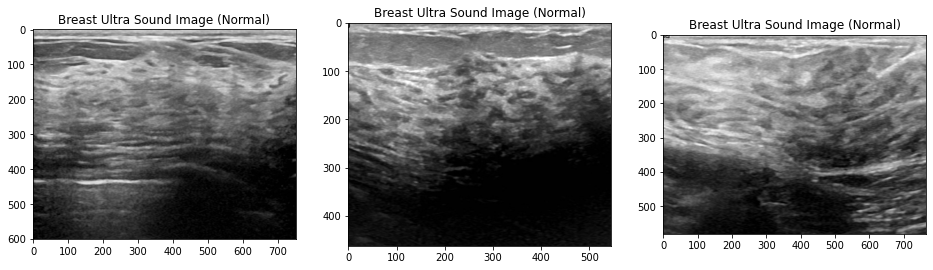

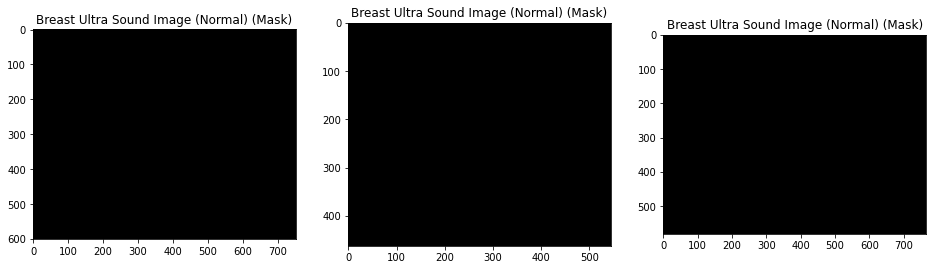

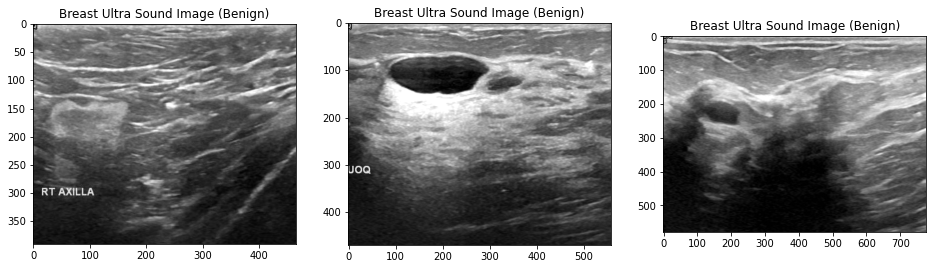

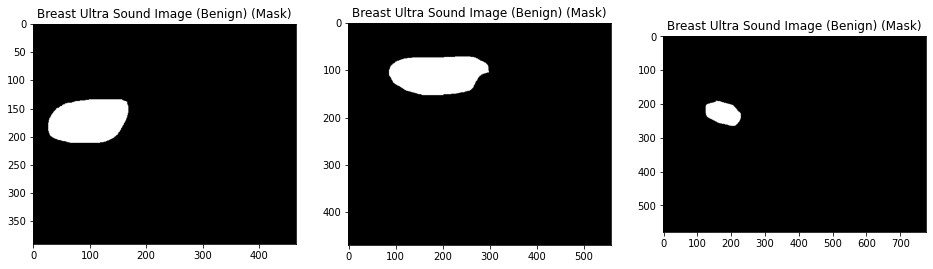

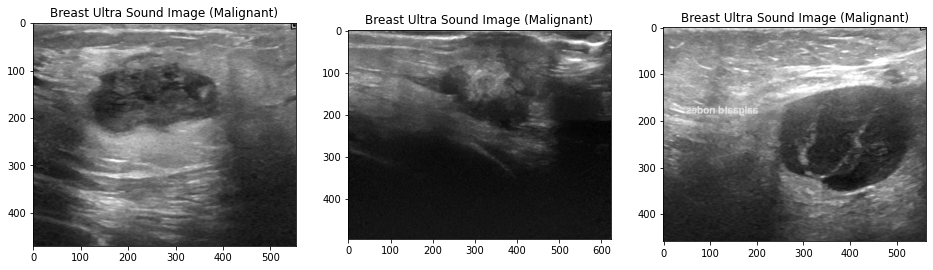

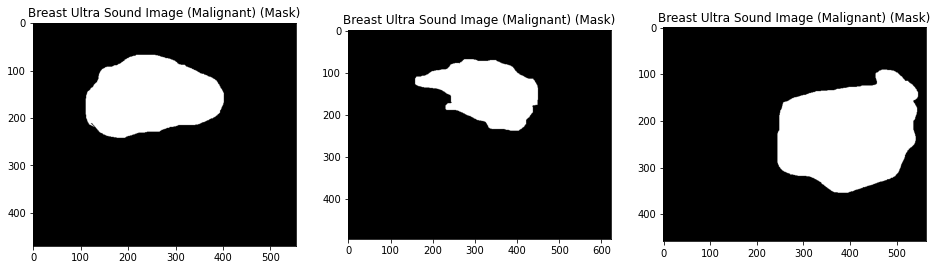

In [6]:
img_title = 'Breast Ultra Sound Image (Normal)'
display_img_list_3(normal_img_list_3, img_title, with_mask= True)

img_title = 'Breast Ultra Sound Image (Benign)'
display_img_list_3(benign_img_list_3, img_title, with_mask= True)

img_title = 'Breast Ultra Sound Image (Malignant)'
display_img_list_3(malignant_img_list_3, img_title, with_mask= True)

### Exploration - Histogram of the 3 random images in each class

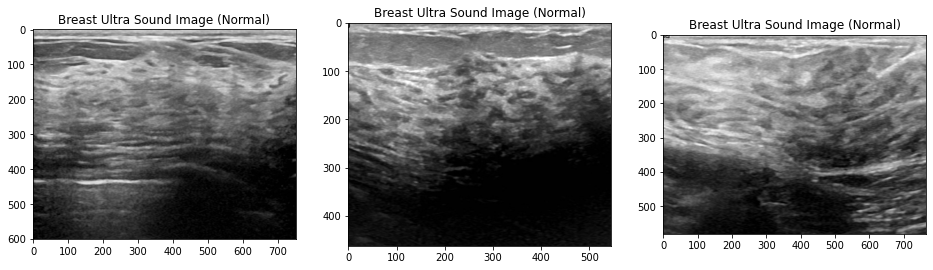

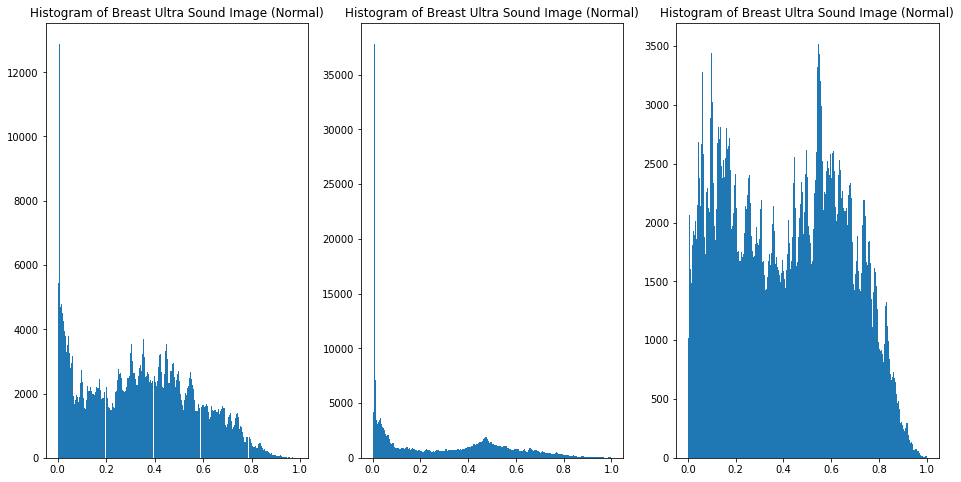

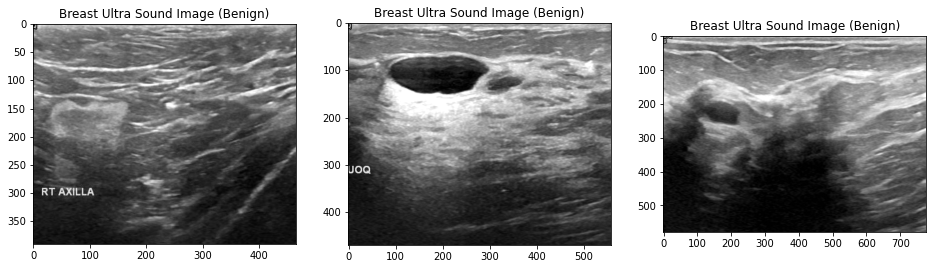

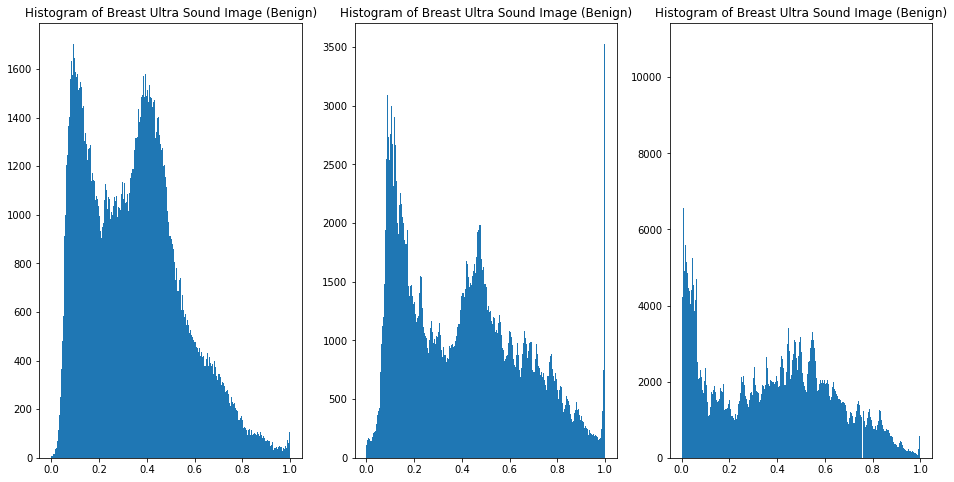

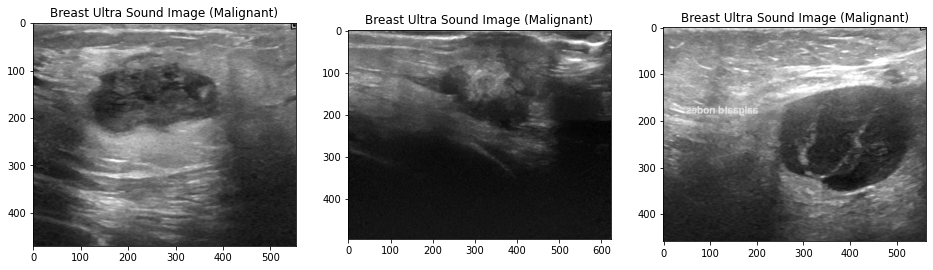

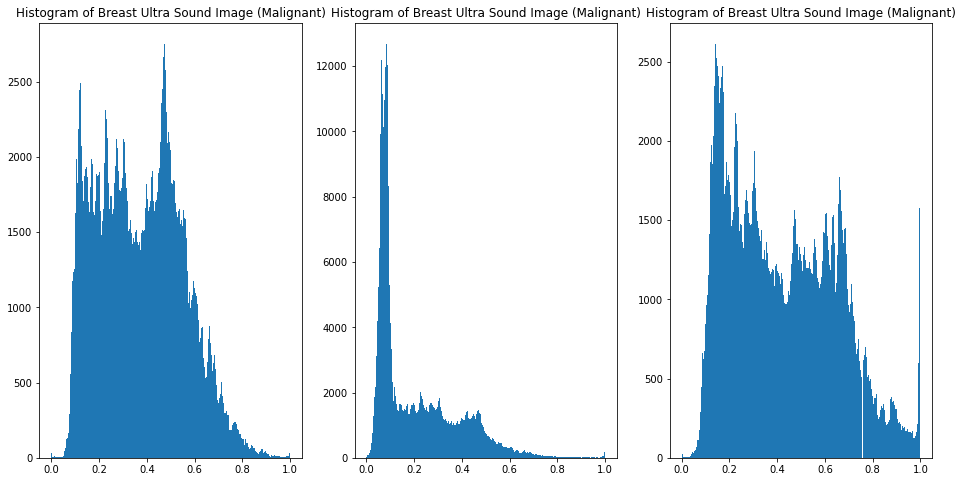

In [7]:
# display historgram of 3 random images from the list
img_title = 'Breast Ultra Sound Image (Normal)'
display_img_list_3(normal_img_list_3, img_title, with_hist= True)

img_title = 'Breast Ultra Sound Image (Benign)'
display_img_list_3(benign_img_list_3, img_title, with_hist= True)

img_title = 'Breast Ultra Sound Image (Malignant)'
display_img_list_3(malignant_img_list_3, img_title, with_hist= True)

#### Exploration - Frequency content of the 3 random images in each class 
Use FFT to compute magnitude of Fourier coefficients and display

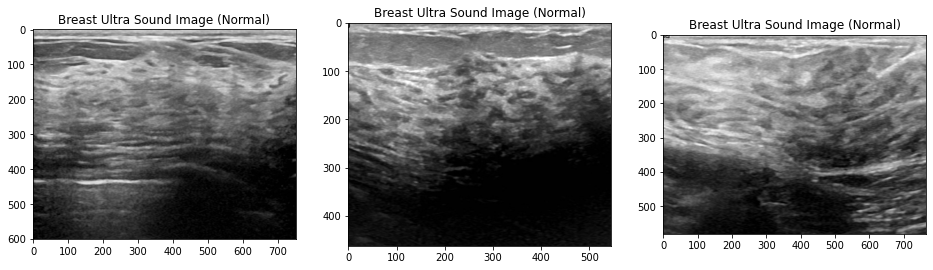

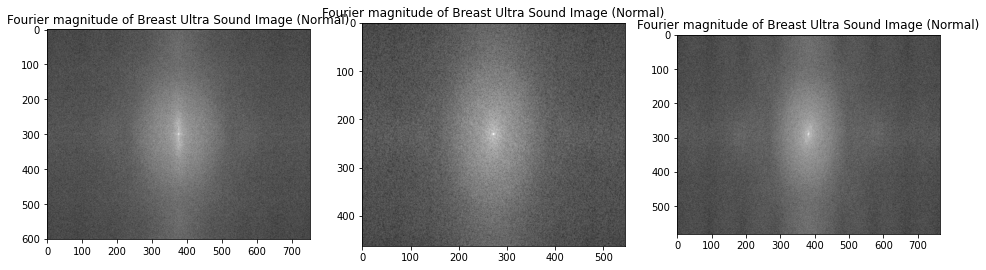

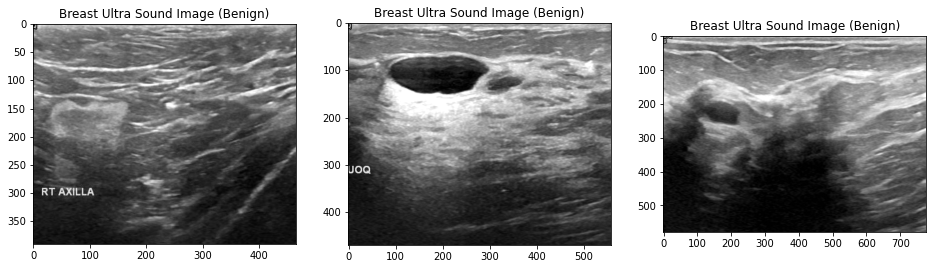

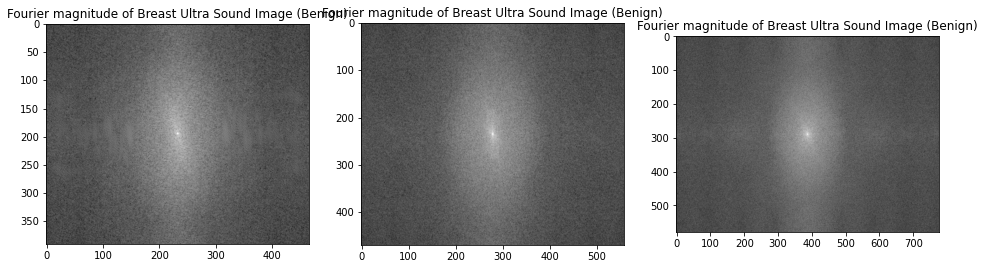

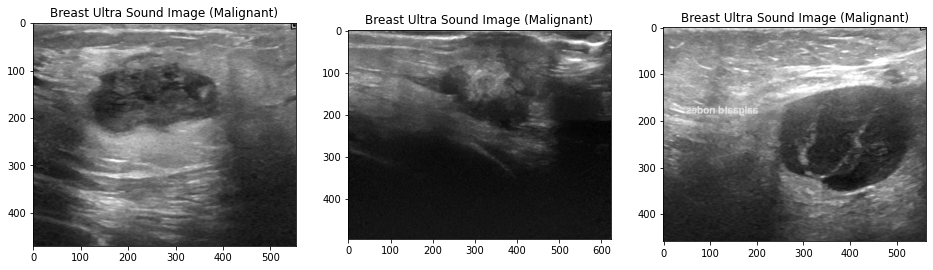

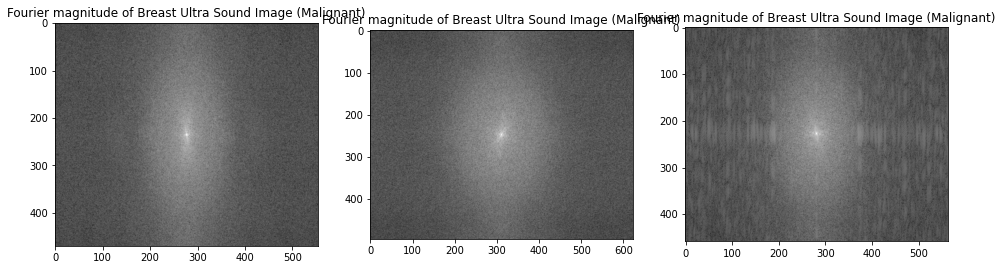

In [8]:
# display Fourier magnitude of 3 random images from the list
img_title = 'Breast Ultra Sound Image (Normal)'
display_img_list_3(normal_img_list_3, img_title, with_fft= True, log= True)

img_title = 'Breast Ultra Sound Image (Benign)'
display_img_list_3(benign_img_list_3, img_title, with_fft= True, log= True)

img_title = 'Breast Ultra Sound Image (Malignant)'
display_img_list_3(malignant_img_list_3, img_title, with_fft= True, log= True)

### Feature Analysis
 0. Prefilter (Historgram equalization)
 1. edge feature extraction (Sobel)
 2. Corner Detection - Feature descriptors (SIFT and ORB)
 3. Low Pass Filtering - Gaussian Filter 

#### Edge detection - Sobel Edge Filters

Original Benign image 1 [ndim, shape, dtype, min, max]: [2, (471, 558), float32, 0.0, 1.0]


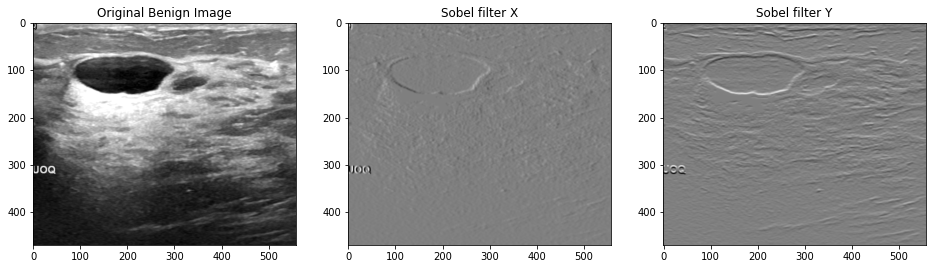

Original Malignant image 1 [ndim, shape, dtype, min, max]: [2, (459, 563), float32, 0.0, 1.0]


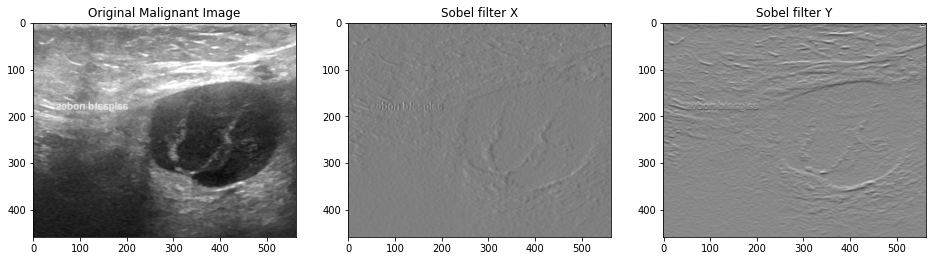

In [9]:
# Sobel filter

# Read a sample image - benign
img_file = benign_img_list_3[1]['file_name_fullpath']
mask_file = benign_img_list_3[1]['file_masks'][0]
img = img_read(img_file, toFloat = True)
img_mask = img_read(mask_file, toFloat = True)

print_ndarray_info(img, "Original Benign image 1")


# Sobel Edge Detection (what is dx and dy) 
# Need to understand what the ddepth is. seems like indicate output destination depth
# Makes much difference using  vs cv2.CV_8Ucv2.CV_32F
sobelx = cv2.Sobel(src= img, ddepth= cv2.CV_32F, dx= 1, dy= 0, ksize= 5) # Sobel Edge Detection on the X axis
sobely = cv2.Sobel(src= img, ddepth= cv2.CV_32F, dx= 0, dy= 1, ksize= 5) # Sobel Edge Detection on the Y axis
#sobelxy = cv2.Sobel(src=img_blur, ddepth= cv2.CV_32F, dx=1, dy=1, ksize=5) # Combined X and Y Sobel Edge Detection

display_3_imgs([img, sobelx, sobely], ["Original Benign Image", "Sobel filter X", "Sobel filter Y"])

# Read a sample image - Malignant
img_file = malignant_img_list_3[2]['file_name_fullpath']
mask_file = malignant_img_list_3[2]['file_masks'][0]
img = img_read(img_file, toFloat = True)
img_mask = img_read(mask_file, toFloat = True)

print_ndarray_info(img, "Original Malignant image 1")

# Sobel Edge Detection (what is dx and dy) 
# Need to understand what the ddepth is. seems like indicate output destination depth
# Makes much difference using  vs cv2.CV_8Ucv2.CV_32F
sobelx = cv2.Sobel(src= img, ddepth= cv2.CV_32F, dx= 1, dy= 0, ksize= 5) # Sobel Edge Detection on the X axis
sobely = cv2.Sobel(src= img, ddepth= cv2.CV_32F, dx= 0, dy= 1, ksize= 5) # Sobel Edge Detection on the Y axis
#sobelxy = cv2.Sobel(src=img_blur, ddepth= cv2.CV_32F, dx=1, dy=1, ksize=5) # Combined X and Y Sobel Edge Detection

display_3_imgs([img, sobelx, sobely], ["Original Malignant Image", "Sobel filter X", "Sobel filter Y"])


Across Multiple randomly selected picture's we've observed in both the benign and malignant categories of the breast cancer modules, we see that the Sobel Y filter, which finds the first order derivatives in the Y direction, is much more effective at picking up the actual edges of the modules and their respective shapes. This is also in line with what we saw in the Fourier Analysis because there was much more variation in the Y direction in our pictures than in the X direction. Following this, we choose the Sobel Y direction feature as something to run on our entire dataset to build this custom feature.

In [10]:
sobel_y_benign = []
sobel_y_malignant = []
for i in benign_im:
    img_blur = cv2.GaussianBlur(img, (3,3), 0) 
    sobely = cv2.Sobel(src= img_blur, ddepth= cv2.CV_32F, dx= 0, dy= 1, ksize= 5) # Sobel Edge Detection on the Y axis
    sobel_y_benign.append(sobely)

for i in malignant_im:
    img_blur = cv2.GaussianBlur(img, (3,3), 0) 
    sobely = cv2.Sobel(src= img_blur, ddepth= cv2.CV_32F, dx= 0, dy= 1, ksize= 5) # Sobel Edge Detection on the Y axis
    sobel_y_malignant.append(sobely)
 

#### Library Based Corner Features - SIFT and ORB

Original Benign image 1 [ndim, shape, dtype, min, max]: [2, (471, 558), uint8, 0, 255]
Blur Benign image 1 [ndim, shape, dtype, min, max]: [2, (471, 558), uint8, 1, 255]


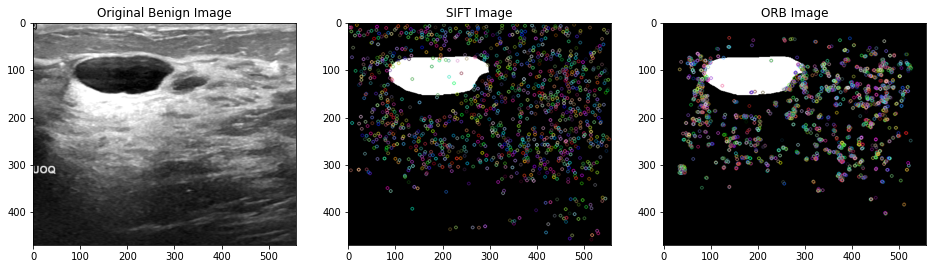

In [11]:
# Read a sample image
img_file = benign_img_list_3[1]['file_name_fullpath']
mask_file = benign_img_list_3[1]['file_masks'][0]
img = img_read(img_file, toFloat = False)
img_float = img_read(img_file, toFloat = True)
img_mask = img_read(mask_file, toFloat = False)

print_ndarray_info(img, "Original Benign image 1")

# Blur the image for better edge detection
img_blur = cv2.GaussianBlur(img, (3,3), 0) 
print_ndarray_info(img_blur, "Blur Benign image 1")

# Create SIFT feature extractor
sift = cv2.SIFT_create()

# detect features (keypoints and descriptors) from the image
keypoints, descriptors = sift.detectAndCompute(img, None)

# Draw the detected key points
# flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
# flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS
sift_image = cv2.drawKeypoints(img_mask, keypoints, 0, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

# ORB
orb = cv2.ORB_create(nfeatures=2000)
keypoints, descriptors = orb.detectAndCompute(img, None)
  
# Drawing the keypoints
#orb_image = cv2.drawKeypoints(img_mask, keypoints, None, color=(0, 255, 0), flags=0)
orb_image = cv2.drawKeypoints(img_mask, keypoints, 0, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

display_3_imgs([img, sift_image, orb_image], ["Original Benign Image", "SIFT Image", "ORB Image"])

In [12]:
orb_benign = []
orb_malignant = []
for i in benign_im: 
    orb = cv2.ORB_create(nfeatures=2000)
    keypoints, descriptors = orb.detectAndCompute(img, None)
    orb_benign.append(keypoints)

for i in malignant_im:
    orb = cv2.ORB_create(nfeatures=2000)
    keypoints, descriptors = orb.detectAndCompute(img, None)
    orb_malignant.append(keypoints)
 

Between the SIFT and ORB features, we've found that the ORB features tend to be more percise in terms of having the most identified edges around the actual adge of the module as well as having the least edges that seep into the cancer module. From the picture above, you can see that the SIFT feature has many edges detected within the module while the ORBonly has 2-3 within the while space of the mask. All of these edges are detected using the origical picture, we just placed the detected edges on the mask to get a better idea of where the detected edges are compared to the actual ultrasound's mask edges. Since the ORB features tended to do better, we went with that feature when creating the custom feature for our entire dataset.

Original Benign image 1 [ndim, shape, dtype, min, max]: [2, (471, 558), uint8, 0, 255]
Blur Benign image 1 [ndim, shape, dtype, min, max]: [2, (471, 558), float64, 4.856128822417329, 254.9733298003715]


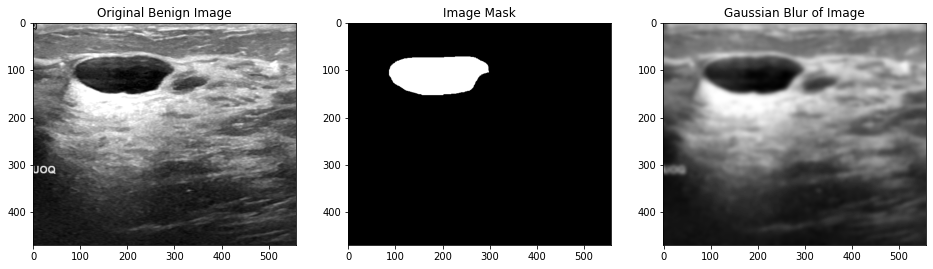

Original Malignant image 1 [ndim, shape, dtype, min, max]: [2, (459, 563), float32, 0.0, 1.0]
Blur Malignant image 1 [ndim, shape, dtype, min, max]: [2, (459, 563), float32, 0.05800290405750275, 0.9831066727638245]


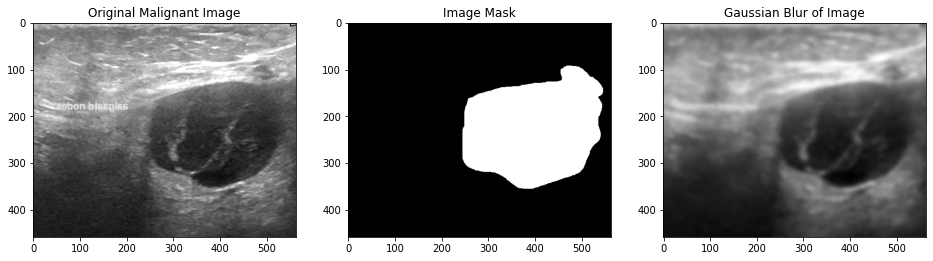

In [ ]:
# Read a sample image - Benign
img_file = benign_img_list_3[1]['file_name_fullpath']
mask_file = benign_img_list_3[1]['file_masks'][0]
img = img_read(img_file, toFloat = False)
img_float = img_read(img_file, toFloat = True)
img_mask = img_read(mask_file, toFloat = False)

print_ndarray_info(img, "Original Benign image 1")

# Blur the image for better edge detection
img_blur = gaussian(img/255,sigma = 4)*255
# img_blur = cv2.GaussianBlur(img, (5,5), 0) 
print_ndarray_info(img_blur, "Blur Benign image 1")

display_3_imgs([img, img_mask, img_blur], ["Original Benign Image", "Image Mask", "Gaussian Blur of Image"])

# Read a sample image - Malignant
img_file = malignant_img_list_3[2]['file_name_fullpath']
mask_file = malignant_img_list_3[2]['file_masks'][0]
img = img_read(img_file, toFloat = True)
img_mask = img_read(mask_file, toFloat = True)

print_ndarray_info(img, "Original Malignant image 1")

# Blur the image for better edge detection
img_blur = gaussian(img/255,sigma = 4)*255
# img_blur = cv2.GaussianBlur(img, (5,5), 0) 
print_ndarray_info(img_blur, "Blur Malignant image 1")

display_3_imgs([img, img_mask, img_blur], ["Original Malignant Image", "Image Mask", "Gaussian Blur of Image"])

We also find that the gaussian filter using a sigma of 4 allows us to blur out some of the edges that seem like they could be relevant in the module but in reality, they are just noise from the ultrasound. We tried sigma 3 through 6 which all still maintained the ingetrigy of the picture, but through all of the random ultrasounds we tested these out on, a sigma of 4 seemed to provide the most universal blur that reduced noise but maintained the modules and allowed them to still be clear. 

# Appendix

Below are all of the other features we have tried and experimented with, but they weren't as good at detecting the edges and characterists of our cancer modules as the ones we have choosen above

#### Edge detection - Canny Edge Filters

Original Benign image 1 [ndim, shape, dtype, min, max]: [2, (471, 558), float32, 0.0, 1.0]


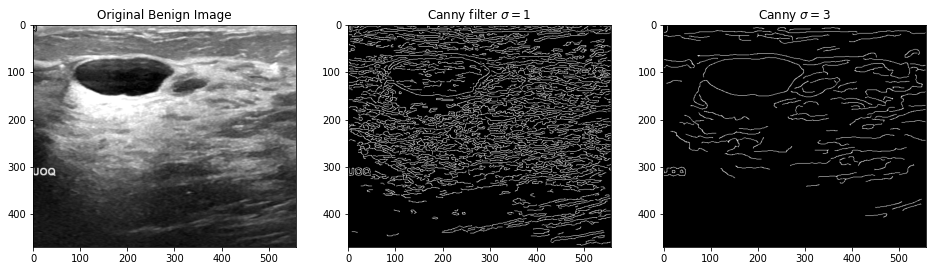

In [20]:
# Sobel filter

# Read a sample image
img_file = benign_img_list_3[1]['file_name_fullpath']
mask_file = benign_img_list_3[1]['file_masks'][0]
img = img_read(img_file, toFloat = True)
img_mask = img_read(mask_file, toFloat = True)

print_ndarray_info(img, "Original Benign image 1")

# CV2 Canny edge detection (works only on UINT 8 data type) but skimage OK on float gray
#canny_edges_1 = cv2.Canny(image= img_blur_unit8, threshold1= 100, threshold2= 255) 
#canny_edges_2 = cv2.Canny(image= img_blur_unit8, threshold1= 100, threshold2= 150)
canny_edges_1 = skimage.feature.canny(img, sigma= 1)
canny_edges_2 = skimage.feature.canny(img, sigma= 3)
display_3_imgs([img, canny_edges_1, canny_edges_2], ["Original Benign Image", "Canny filter $\sigma = 1$", "Canny $\sigma = 3$"])

#### Edge detection - Prewitt Horizontal and Vertical Edges

Benign image 1 [ndim, shape, dtype, min, max]: [2, (471, 558), float32, 0.0, 1.0]


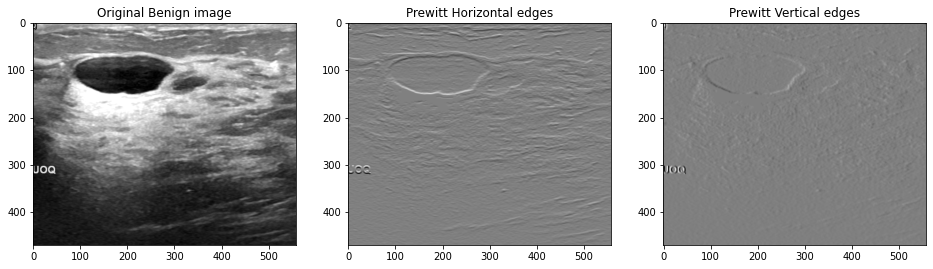

In [21]:
# Prewitt Edge feature extraction

img_file = benign_img_list_3[1]['file_name_fullpath']
img = img_read(img_file, toFloat = True)
print_ndarray_info(img, "Benign image 1")

# Extract horizontal and vertical edges using prewitt kernel
edges_prewitt_horizontal = prewitt_h(img)
edges_prewitt_vertical = prewitt_v(img)

img_title_list = ["Original Benign image", "Prewitt Horizontal edges",  "Prewitt Vertical edges"]
display_3_imgs([img, edges_prewitt_horizontal, edges_prewitt_vertical], img_title_list)

#### Corner features - Harris and Shi-Tomasi

Original Malignant image 1 [ndim, shape, dtype, min, max]: [2, (470, 554), float32, 0.0, 1.0]
Blur Malignant image 1 [ndim, shape, dtype, min, max]: [2, (470, 554), float32, 0.007598039694130421, 0.9977941513061523]


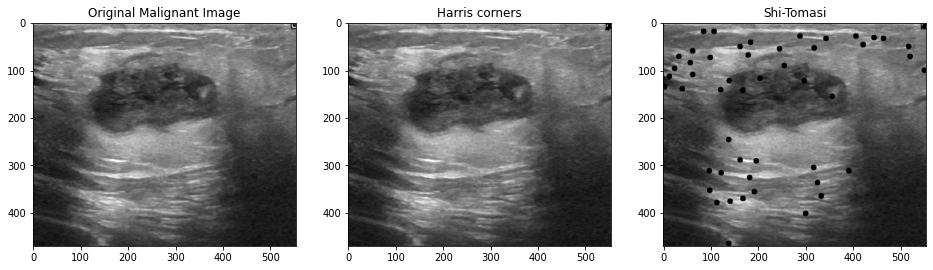

In [22]:
# Read a sample image
img_file = malignant_img_list_3[0]['file_name_fullpath']
mask_file = malignant_img_list_3[0]['file_masks'][0]
img = img_read(img_file, toFloat = True)
img_mask = img_read(mask_file, toFloat = True)

print_ndarray_info(img, "Original Malignant image 1")

# Blur the image for better edge detection
img_blur = cv2.GaussianBlur(img, (3,3), 0) 
print_ndarray_info(img_blur, "Blur Malignant image 1")

# Haris corner detection
dst = cv2.cornerHarris(img, blockSize=2, ksize=3, k=0.04)
  
# dilate to mark the corners
dst = cv2.dilate(dst, None)
img_cp = img.copy()
img_cp[dst > 0.01 * dst.max()] = 0

# Shi-Tomasi corner detection
corners = cv2.goodFeaturesToTrack(img, maxCorners=50, qualityLevel=0.02, minDistance=20)
corners = np.float32(corners)

img_cp2 = img.copy() 
for item in corners:
    x, y = item[0]
    x = int(x)
    y = int(y)
    cv2.circle(img_cp2, (x, y), 6, (0, 255, 0), -1)

display_3_imgs([img, img_cp, img_cp2], ["Original Malignant Image", "Harris corners", "Shi-Tomasi"])